# Import packages

In [1]:
# loading packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
plt.rcParams['figure.dpi'] = 300

import matplotlib.dates as mdates

# ignoring warnings
import warnings
warnings.simplefilter("ignore")

In [2]:
import sklearn as sk
import statsmodels.api as sm

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.api import ARMA


from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson

from sklearn.metrics import r2_score,mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor

import copy

# Custom functions

In [3]:
def diff_for_stationarity(df_input,cols,threshold):
    
    """Checks the series for stationarity then difference it until it is stationary
    (with the given threshold)"""
    
    df = copy.deepcopy(df_input)
    
    
    # Get length of DF
    n = len(df)
    
    # Loop over columns of interest
    for col in cols:
        stationarity = False
        series = list(df[col].astype(float))
        linear_diff = False
        
        try:
        
            counter = 0



            while not stationarity:

                #print(counter)

                # Run ADF test
                adf_test = adfuller(series)
                pval = adf_test[1]

                if pval < threshold:
                    stationarity = True

                else:
                    # Difference the series
                    #series = [np.log(series[i]/series[i-1]) for i in range(1,n-counter)]
                    series = [series[i]-series[i-1] for i in range(1,n-counter)]

                    counter += 1
                    
        except:
            
            counter = 0
            stationarity = False
            series = list(df[col].astype(float))
            linear_diff = True

            while not stationarity:

                #print(counter)

                # Run ADF test
                adf_test = adfuller(series)
                pval = adf_test[1]

                if pval < threshold:
                    stationarity = True

                elif counter>1:
                    stationarity = True
                    series = list(df[col].astype(float))
                else:
                    # Difference the series
                    series = [series[i]-series[i-1] for i in range(1,n-counter)]

                    counter += 1
        
        # Create final series and assign it back to the dataframe
        final_series = [None]*counter + series
        df[col] = final_series
        
        if linear_diff:
            type_diff = "linear difference"
        else:
            type_diff = "linear difference"
        
        print("Variable: {} is {}-order integrated ({})!".format(col,counter,type_diff))
        
        
    return df

# Import data

In [4]:
df = pd.read_csv('../Data/weekly_prices.csv')

df.set_index('Date',inplace=True)

print(df.head())

                       Price
Date                        
2008-04-07 00:00:00  25.3525
2008-04-14 00:00:00  26.1800
2008-04-21 00:00:00  26.3580
2008-04-28 00:00:00  25.5320
2008-05-05 00:00:00  26.4700


# EDA

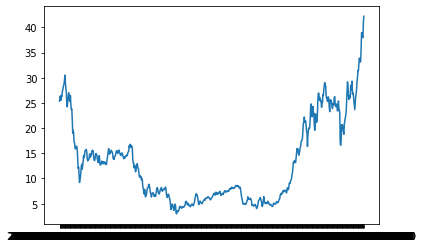

In [5]:
plt.plot(df.Price)
plt.show()

# Data preprocessing

## Handle missing values

In [8]:
df = df.fillna(method='bfill')

## Stationarity checks

In [9]:
# Parameters
stacioner_threshold = 0.01
arno_cols = df.columns
current_df = df

# Check for stationarity
df_stationer = diff_for_stationarity(df_input=current_df,cols=arno_cols,threshold=stacioner_threshold)

Variable: Price is 1-order integrated (linear difference)!


In [10]:
df_stationer

,Price
Date,
2008-04-07 00:00:00,NaN
2008-04-14 00:00:00,0.827500
2008-04-21 00:00:00,0.178000
2008-04-28 00:00:00,-0.826000
2008-05-05 00:00:00,0.938000
...,...
2021-02-15 00:00:00,-0.556000
2021-02-22 00:00:00,-0.182000
2021-03-01 00:00:00,-0.242000


In [11]:
# Drop first row after differencing the series
df_stationer = df_stationer.dropna()

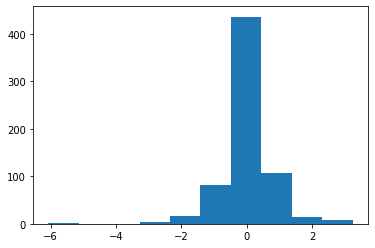

In [13]:
plt.hist(df_stationer.Price)
plt.show()

# Modelling

In [14]:
# Create train-test sets
n = len(df_stationer)
testsize = 0.2

test_obs = int(n*testsize)
df_train, df_test = df_stationer[0:-test_obs], df_stationer[-test_obs:]

# Check size
print(df_train.shape)
print(df_test.shape)

# Be careful with time leakage!

(536, 1)
(133, 1)


## ARMA(p,q)

In [15]:
# Fit the model
res = sm.tsa.arma_order_select_ic(df_train['Price'], ic=["aic", "bic","hqic"], trend="nc")

In [16]:
print(res)

{'aic':             0           1           2
0         NaN  765.527008  765.901263
1  773.916066  764.817023  766.217130
2  773.252896  765.393983  763.370898
3  766.259213  761.768436  758.890751
4  758.698993  760.058028  758.889415, 'bic':             0           1           2
0         NaN  774.095276  778.753665
1  782.484334  777.669425  783.353666
2  786.105298  782.530520  784.791569
3  783.395749  783.189107  784.595556
4  780.119664  785.762833  788.878354, 'hqic':             0           1           2
0         NaN  768.879120  770.929431
1  777.268178  769.845191  772.921354
2  778.281064  772.098208  771.751179
3  772.963437  770.148717  768.947087
4  767.079273  770.114365  770.621808, 'aic_min_order': (4, 0), 'bic_min_order': (0, 1), 'hqic_min_order': (4, 0)}


In [21]:
# Parameters
order = (0,1)

# Initialise model
arma_model = ARMA(df_train['Price'],order)

In [22]:
# Fit the model with the selected order
arma_model_fitted = arma_model.fit()
arma_model_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Price   No. Observations:                  536
Model:                     ARMA(0, 1)   Log Likelihood                -380.734
Method:                       css-mle   S.D. of innovations              0.492
Date:                Thu, 18 Mar 2021   AIC                            767.467
Time:                        22:51:33   BIC                            780.320
Sample:                             0   HQIC                           772.496
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0071      0.029     -0.244      0.807      -0.064       0.050
ma.L1.Price     0.3726      0.045      8.357      0.000       0.285       0.460
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -2.6839           +0.0000j            2.6839            0.5000
-----------------------------------------------------------------------------
"""

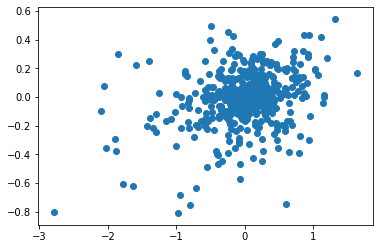

In [24]:
# Compare prediction and actual
arma_y_pred = arma_model.predict(params = arma_model_fitted.params)
y_true = df_train['Price']

plt.scatter(y_true,arma_y_pred)
plt.show()

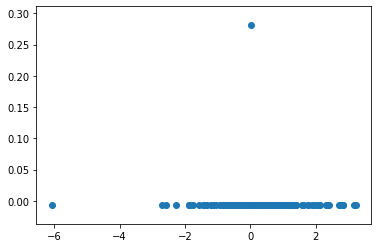

In [25]:
# Compare prediction and actual
arma_y_pred_test = arma_model.predict(params = arma_model_fitted.params,
                                     start = len(df_train),
                                     end = len(df_train)+len(df_test)-1)
y_test = df_test['Price']

plt.scatter(y_test,arma_y_pred_test)
plt.show()

## Random forest

In [26]:
rf_model = RandomForestRegressor(max_depth=5, n_estimators=30, random_state=0)

In [39]:
X_train = df_train.shift(1).iloc[1:,:].values

y_train = df_train['Price'].iloc[1:]

X_test = df_test.shift(1).iloc[1:,:].values

y_test = df_test['Price'].iloc[1:]

In [41]:
# Fit the model
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [42]:
# Predict with the model
rf_y_pred = rf_model.predict(X_test)

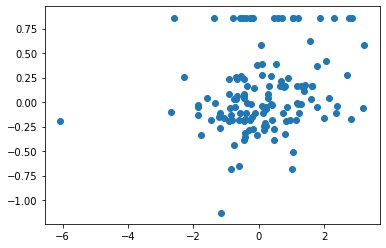

In [44]:
# Compare prediction and actual in the test set
plt.scatter(y_test,rf_y_pred)
plt.show()

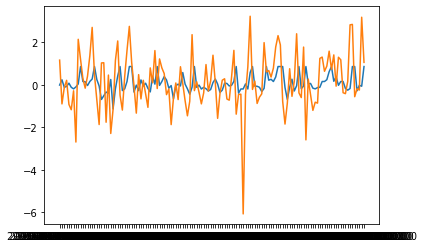

In [45]:
# Compare prediction and actual in the test set
plt.plot(rf_y_pred)
plt.plot(y_test)
plt.show()

In [46]:
mean_squared_error(rf_y_pred,y_test)

1.670959490240643